## Auto Encoding K-MEANS using categorical variables
* 딥러닝을 이용하여 변수 encoding 압축 작업 후 k-means clustering 진행
* 산업 분류 코드 추가
    * 한국표준산업분류를 참조하여 대분류 코드로 변환
    * 일부 산업들의 유사성, 빈도를 고려하여 병합
* 연속 변수 카테고리화
    * 이유
        * 변수 추가를 해도 연속형 변수는 많지 않음, 범주형, 연속형 9 : 1 비율임
        * 연속 변수 추가 시 표준화, 축소 작업을 해도 값들이 멀리 퍼져있는 경향의 데이터들이 많음

In [1]:
import pandas as pd
import pandasgui as gui
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import SGD

### KLIPS(노동패널) Data set
* 50-65세인 취업자에 한함

In [2]:
# 변수명이 들어있는 Text 파일을 읽어 변수명 리스트를 반환하는 함수
def readColumns(filepath):
    with open(filepath, "r") as f:
        return [s.replace("\n","") for s in f.readlines()] # 개행문자 제거된 변수명 리스트 반환

In [3]:
# 데이터 읽기(개인용, 직업력)
df_p = pd.read_excel('dataFiles/klips/klips23p.xlsx', usecols=readColumns('variables/p_categorical.txt')) # 개인용
df_j = pd.read_excel('dataFiles/klips/klips23w.xlsx', usecols=readColumns('variables/j_categorical.txt')) # 직업력

df_p = df_p[(df_p['p230201']==1) & ((df_p['p230107']>=50) & (df_p['p230107']<=65))] # 취업자, 50세이상 65세이하
df_j = df_j[df_j['jobwave']==23]

### Data preprocessing
* 결측치 대체, 제거
* 카테고리 축소
* 변수 생성

In [4]:
df = pd.merge(df_p, df_j, on='pid',how='left') # 병합

# 산업분류코드, 작년세후총연간근로소득 결측값 인덱스 삭제
df.drop((df[df['p230342']==np.NaN].index) | (df[df['p231703']==np.NaN].index), inplace=True) 


for col in df.columns: # 결측값 대체
    df[col] = df[col].fillna(df[col].max()+1) # 변수 값의 맨 마지막 번호 + 1

# 일자리형태 3번(해당없음) 삭제 -> 임금 비임금만 있어야 함
df.drop((df[df['jobtype']==3].index), inplace=True) 

for col in df.columns: # -1 값 삭제
    df.drop(df[df[col] == -1].index, inplace=True)

In [5]:
# 카테고리 축소 5개 -> 3개

# 직업 몰입도, 만족도 질문과 건강상태
for col in df.columns[11:34]:
    df.replace({col:[1,2]},1, inplace=True)
    df.replace({col:[3]},2, inplace=True) 
    df.replace({col:[4,5]},3, inplace=True) 
    df.replace({col:[6]}, 4, inplace=True) # 해당없음
    
# 사회 경제적 지위
df.replace({'p236615':[1,2]}, 1, inplace=True) # 상
df.replace({'p236615':[3,4]}, 2, inplace=True) # 중
df.replace({'p236615':[5,6]}, 3, inplace=True) # 하

# 학력
df.replace({'p230110':[1,2,3]}, 1, inplace=True) # 초졸이하
df.replace({'p230110':[4]}, 2, inplace=True) # 중졸
df.replace({'p230110':[5]}, 3, inplace=True) # 고졸
df.replace({'p230110':[6,7,8,9]}, 4, inplace=True) # 대졸이상

# 유형
# 유형 홀수번 : 현재 하고 있음
# 유형 짝수번 : 지금은 그만 두었음
# 취업자 통제에서 유형 짝수번은 없다고 판단되나, 있을 가능성 존재
df.replace({'jobclass':[1,2]}, 1, inplace=True) # 유형1 + 유형2:  임금, 지난 조사 당시 일자리 여부 있었음
df.replace({'jobclass':[3,4]}, 2, inplace=True) # 유형3 + 유형4:  비임금, 지난 조사 당시 일자리 여부 있었음
df.replace({'jobclass':[5,6]}, 3, inplace=True) # 유형5 + 유형6:  임금, 지난 조사 당시 일자리 여부 없었음
df.replace({'jobclass':[7,8]}, 4, inplace=True) # 유형7 + 유형8:  비임금, 지난 조사 당시 일자리 여부 없었음

# 기업형태
df.replace({'p230401':[1]}, 1, inplace=True) # 민간회사 또는 개인 사업체
df.replace({'p230401':[2]}, 2, inplace=True) # 외국인 회사
df.replace({'p230401':[3,4,5]}, 3, inplace=True) # 정부기관, 법인단체, 공사합동기업
df.replace({'p230401':[6,7,8]}, 4, inplace=True) # 기타 또는 소속없음
df.replace({'p230401':[9]}, 5, inplace=True) # 해당없음

# 음주빈도
df.replace({'p236162':[1,2]}, 1, inplace=True) # 월 3회 이하
df.replace({'p236162':[3,4]}, 2, inplace=True) # 주 4회 이하
df.replace({'p236162':[5]}, 3, inplace=True) # 거의 매일
df.replace({'p236162':[6]}, 4, inplace=True) # 안마심

In [6]:
# 연속 변수 카테고리화
df['p231703'] = df['p231703'].astype(int) # 작년세후총연간근로소득 integer 변환

df.loc[df['p230107'] <= 54 , 'age'] = 1 # <=54세
df.loc[(df['p230107'] >= 55) & (df['p230107'] <= 59) , 'age'] = 2 # 55-59세
df.loc[(df['p230107'] >= 60) , 'age'] = 3 # >=60세

df.loc[df['p231703'] <= 2249 , 'inc'] = 1 # <=2249만원
df.loc[(df['p231703'] >= 2250) & (df['p231703'] <= 3799) , 'inc'] = 2 # 2250-3799만원
df.loc[(df['p231703'] >= 3800) , 'inc'] = 3 # >=3800만원


### 산업 대분류 및 일부 묶음
* 대분류는 알파벳으로 표기
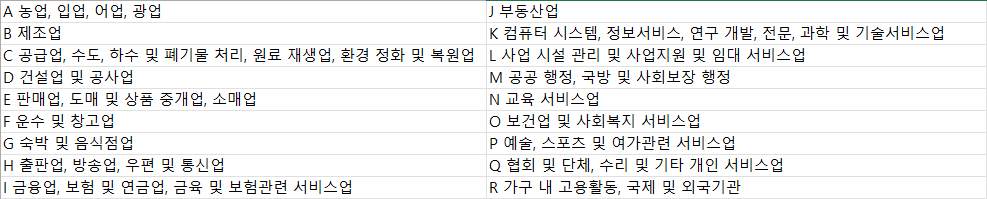


In [7]:
# 산업코드 중분류 계산
df['p230342'] = df['p230342'] // 10
df['p230342'].astype(int)
ksic = df['p230342'].to_numpy()

print(ksic)

[42. 62. 68. ... 26. 32. 74.]


In [8]:
df['KSIC'] = np.NaN # 대체 변수 생성
df.columns.get_loc('KSIC') # 변수 위치 확인

63

In [9]:
A = [1, 2, 3, 5, 7]; B = [i for i in range(10,34)]; C = [35, 36, 37, 38, 39]
D = [41, 42];        E = [45, 46, 47];              F = [49, 50, 51, 52]
G = [55, 56];        H = [58, 60, 61];              I = [64, 65, 66]
J = [68];            K = [62, 63, 70, 71, 72, 73];  L = [74, 75, 76]
M = [84];            N = [85];                      O = [86, 87]
P = [90, 91];        Q = [34, 94, 95, 96];          R = [97, 99]

_list = [A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R]
alpha = [chr(i).upper() for i in range(97,115)] # 대문자 'A' - 'R' 리스트

for i in range(len(ksic)):
    for j, code in enumerate(_list) :
        if np.isin(ksic[i], code) : # 원소가 리스트에 존재하는지 체크
            df.iloc[i, 63] = alpha[j] # iloc 함수 사용하여 값 처리
            break

In [10]:
# 대분류 대체 값 확인
df[['p230342','KSIC']]

,p230342,KSIC
0,42.0,D
1,62.0,K
2,68.0,J
3,46.0,E
4,46.0,E
...,...,...
4709,47.0,E
4710,47.0,E
4711,26.0,B
4712,32.0,B


In [11]:
# 연속형 변수인 나이, 소득은 따로 복제
# 클러스터 분석 평균 그래프에 이용됨.
df_age_sincome = df[['p230107', 'p231703']].copy()

for col in df.columns: # object 타입으로 변환
    df[col] = df[col].astype(str)

df_klips = df.copy()

# pid와, p230201(취업자만), 산업분류코드(새변수 KSIC 대체), 나이, 소득, jobwave는 사용하지 않음
df_klips.drop(['pid','p230201', 'p230342', 'p230107', 'p231703', 'jobwave'],axis=1, inplace=True) 
df_klips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 0 to 4713
Data columns (total 58 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   p230101   4659 non-null   object
 1   p230110   4659 non-null   object
 2   jobtype   4659 non-null   object
 3   p230401   4659 non-null   object
 4   p230501   4659 non-null   object
 5   p230508   4659 non-null   object
 6   p234201   4659 non-null   object
 7   p234202   4659 non-null   object
 8   p234203   4659 non-null   object
 9   p234204   4659 non-null   object
 10  p234205   4659 non-null   object
 11  p234301   4659 non-null   object
 12  p234302   4659 non-null   object
 13  p234303   4659 non-null   object
 14  p234304   4659 non-null   object
 15  p234305   4659 non-null   object
 16  p234311   4659 non-null   object
 17  p234312   4659 non-null   object
 18  p234313   4659 non-null   object
 19  p234314   4659 non-null   object
 20  p234315   4659 non-null   object
 21  p234316   4659

In [12]:
# 더미변수 생성 후 numpy 배열로 변환
df_kmeans = df_klips.copy() # k-means
df_kmeans_dum2num = pd.get_dummies(df_kmeans).to_numpy() 
print('[kmeans numpy data]\n',df_kmeans_dum2num)
print('kmeans numpy data shape : ',df_kmeans_dum2num.shape)

[kmeans numpy data]
 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]
kmeans numpy data shape :  (4659, 207)


### Auto Encoder & fit model

In [13]:
input_data = Input(shape=(207,))

# encoder
x = Dense(128,activation='relu')(input_data)
x = Dense(64,activation='relu')(x)
encoder = Dense(2, activation='relu')(x)

# decoder
x = Dense(64, activation='relu')(encoder)
x = Dense(128,activation='relu')(x)
decoder = Dense(207,activation='relu')(x)

# fit model
auto_encoder = Model(inputs=input_data, outputs=decoder)
auto_encoder.compile(optimizer='adam', loss='mean_squared_error')

auto_encoder.fit(df_kmeans_dum2num, df_kmeans_dum2num,
                batch_size=8, epochs=200, verbose=0)

In [14]:
auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 207)]             0         
                                                                 
 dense (Dense)               (None, 128)               26624     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 207)               26703 

### Get latent layer
* 압축된 데이터로 KMEANS 학습

In [15]:
# Latent layer
latent_layer = Model(inputs=input_data, outputs=encoder)
pred = latent_layer.predict(df_kmeans_dum2num)
pred.shape

146/146 [==============================] - 0s 1ms/step


(4659, 2)

In [16]:
# pred x, y 값 할당
for i, col in enumerate(['x','y']):
    df_kmeans['pred_'+col] = pred[:,i]

Text(0, 0.5, 'cost')

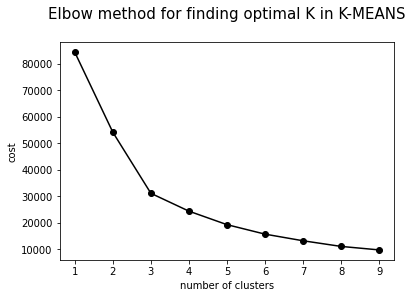

In [17]:
kmeans_cost = []
K_list = range(1, 10)
for k in K_list:
    # K-MEANS
    kmeans = KMeans(n_clusters=k, init='k-means++',random_state=10)
    kmeans.fit(pred)
    kmeans_cost.append(kmeans.inertia_)
    df_kmeans['cluster_'+ str(k)] = kmeans.fit_predict(pred)+1

plt.plot(K_list, kmeans_cost, 'o-',color='black')
plt.title('Elbow method for finding optimal K in K-MEANS' + '\n',fontsize=15)
plt.xlabel('number of clusters')
plt.ylabel('cost')

In [18]:
df_kmeans.columns[60:69] # cluster 변수 확인

Index(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'],
      dtype='object')

### K개의 군집별 산점도 그래프

In [19]:
import seaborn as sns
plt.rc("font", family="Malgun Gothic")
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False}, 
        style='darkgrid')

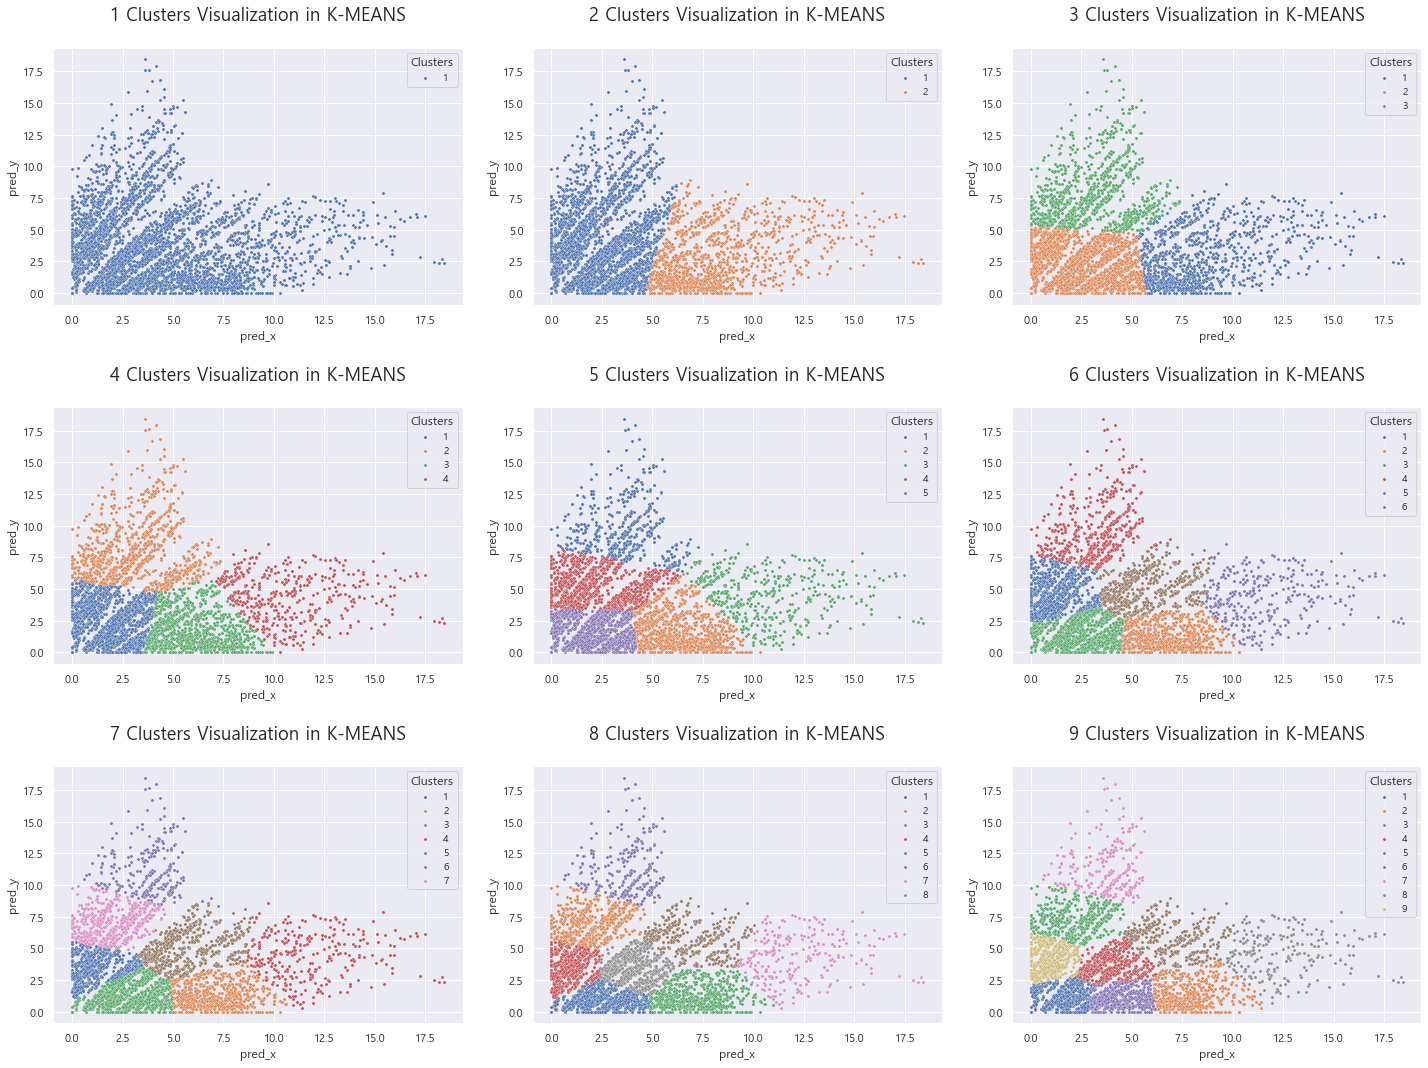

In [20]:
cols = [col for col in df_kmeans.columns[60:69]]
fig = plt.figure(figsize=(20,15))
axes = [i+331 for i in range(9)]
cms =[]
for i, (col,ax) in enumerate(zip(cols, axes)):
    axs = fig.add_subplot(ax)
    cm = sns.color_palette('hls',len(df_kmeans[col].unique()))
    for j in range(i+1):
        marker_ind = df_kmeans[df_kmeans[col]==j+1].index
        sns.scatterplot(x=df_kmeans.loc[marker_ind, 'pred_x'],
                    y=df_kmeans.loc[marker_ind, 'pred_y'],
                    marker='o', s=10, palette=cm)
        axs.set_title(str(i+1) + ' Clusters Visualization in K-MEANS' +'\n',fontsize=18)
        axs.legend(labels=[label+1 for label in range(i+1)] ,fontsize=10,title='Clusters')
    cms.append(cm)
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()
        

### K개의 군집별 일부 특성에 따른 빈도, 평균(나이, 소득) 그래프

In [21]:
df_kmeans = pd.concat([df_kmeans, df_age_sincome],axis=1) # 기존 저장된 나이, 소득 연속 변수 합치기

In [22]:
# 산업분류 순서화 (A - R)
from pandas.api.types import CategoricalDtype
df_kmeans['KSIC'] = df['KSIC'].astype(CategoricalDtype(categories = [chr(i).upper() for i in range(97,115)], 
                                                       ordered = True))

In [23]:
import seaborn as sns

def drawCountPlot(df, colname) : # (데이터 셋, 변수이름)
    clusters = [col for col in df.columns[60:69]]
    fig = plt.figure(figsize=(20,20))
    axes = [i+331 for i in range(9)]

    for i, (cluster,ax) in enumerate(zip(clusters, axes)):
        axs = fig.add_subplot(ax)
        sns.countplot(x=df[colname], palette=cms[i], order=None,
                     hue=df[cluster], ax=axs)
        axs.set_title( 'Frequency of ' + colname + ' by Clusters '+ ' for ' + str(i+1) + ' Cluster',fontsize=18)
        axs.legend(labels=[label+1 for label in range(i+1)] ,fontsize=10,title='Clusters',loc='lower right')

    plt.tight_layout(h_pad=1, w_pad=1)
    plt.show()

### K개 클러스터의 일부 요인별 클러스터 빈도표
* 산업대분류 참고(**바로 확인은 안됨. 일부 산업들 병합하여 범주 값 축소 필요**)
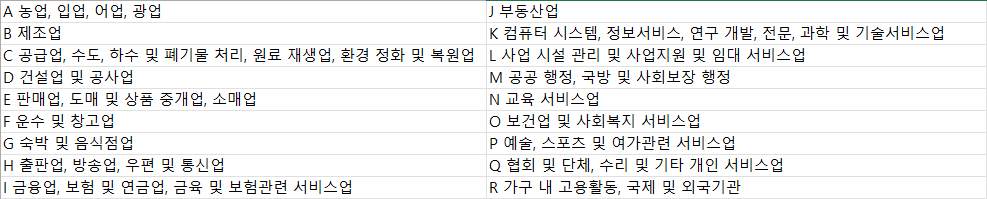

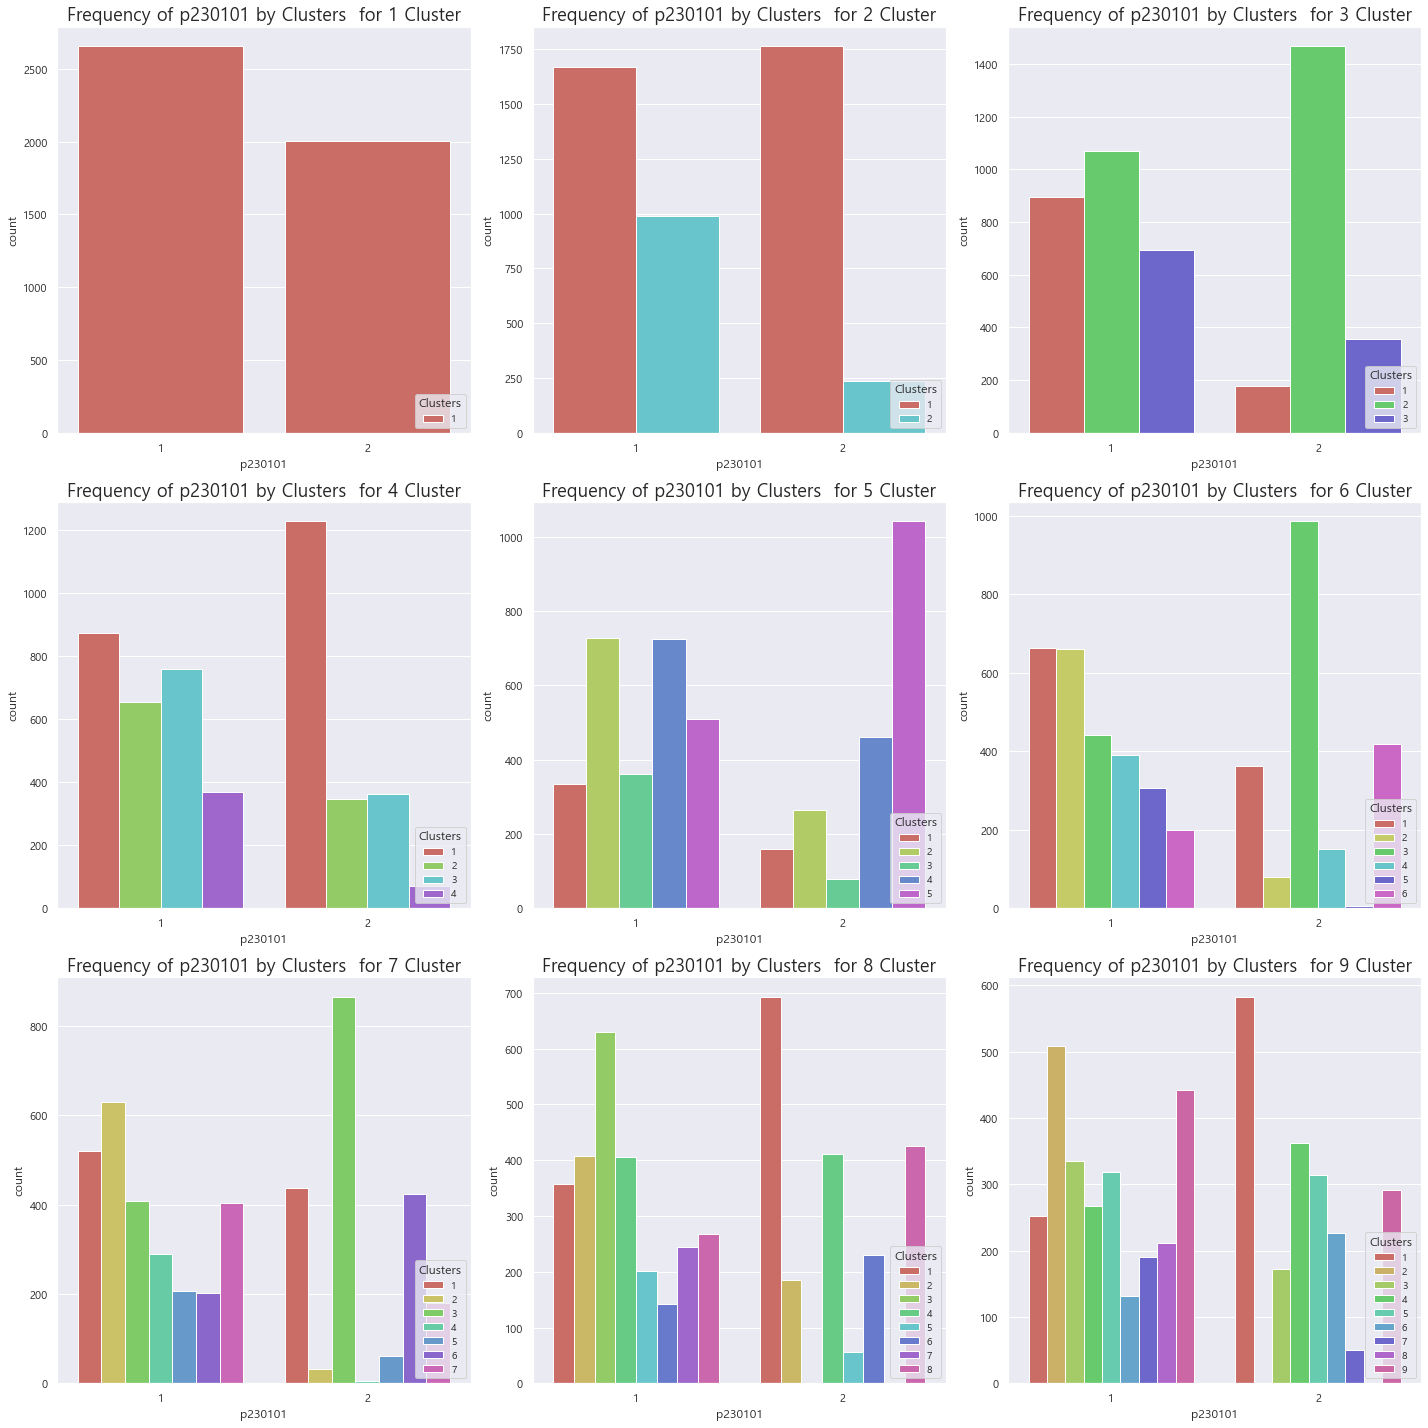

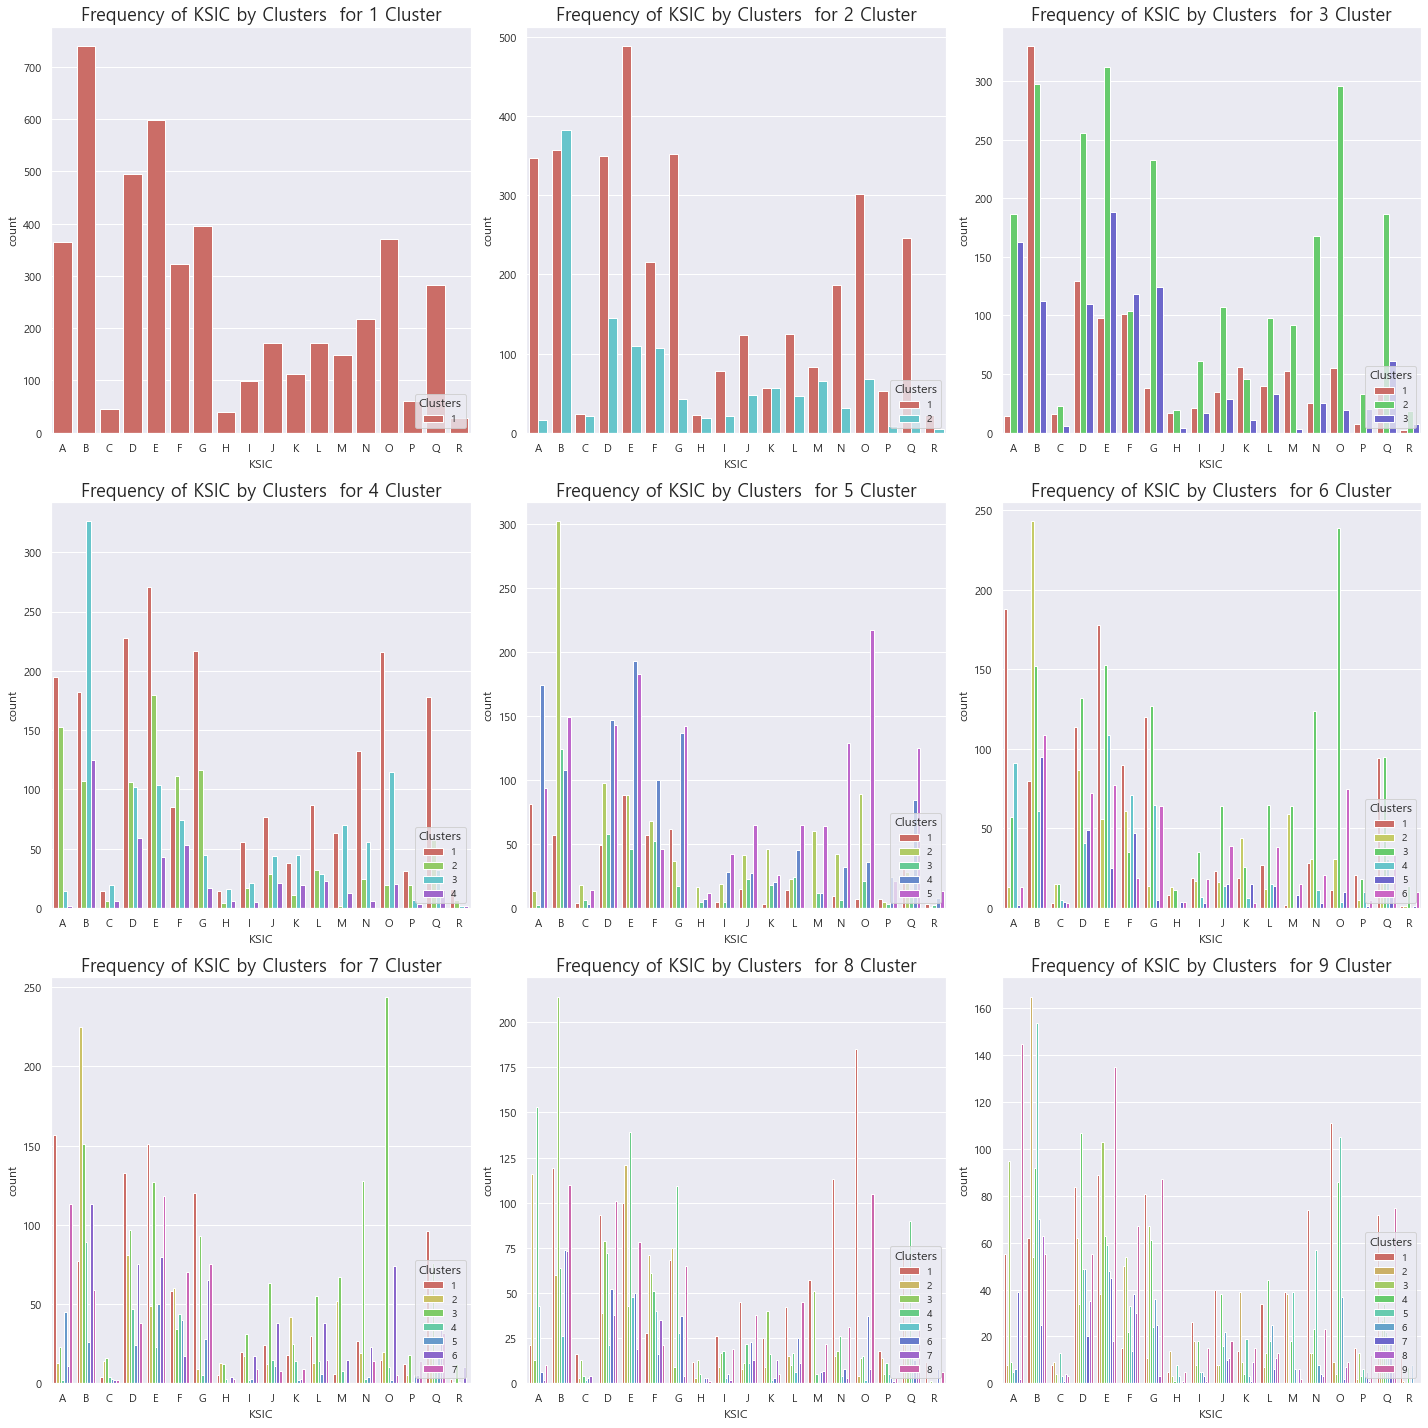

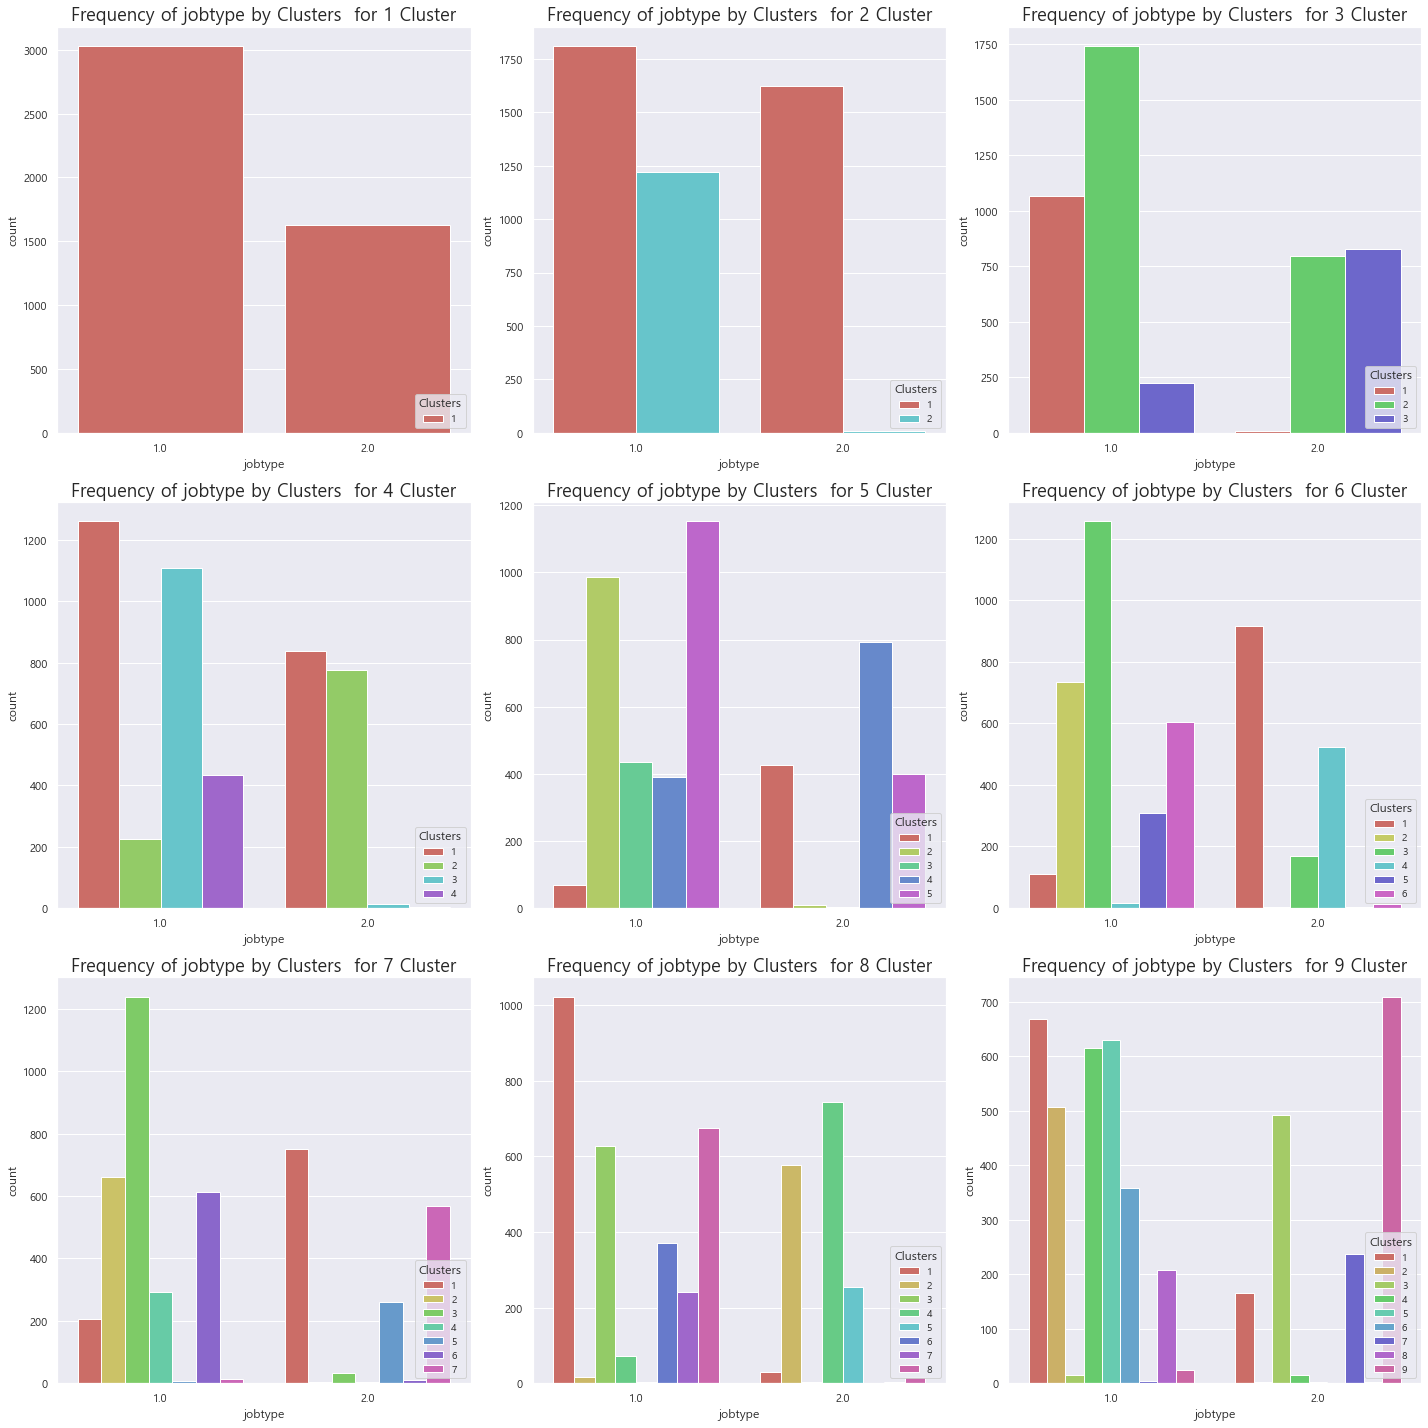

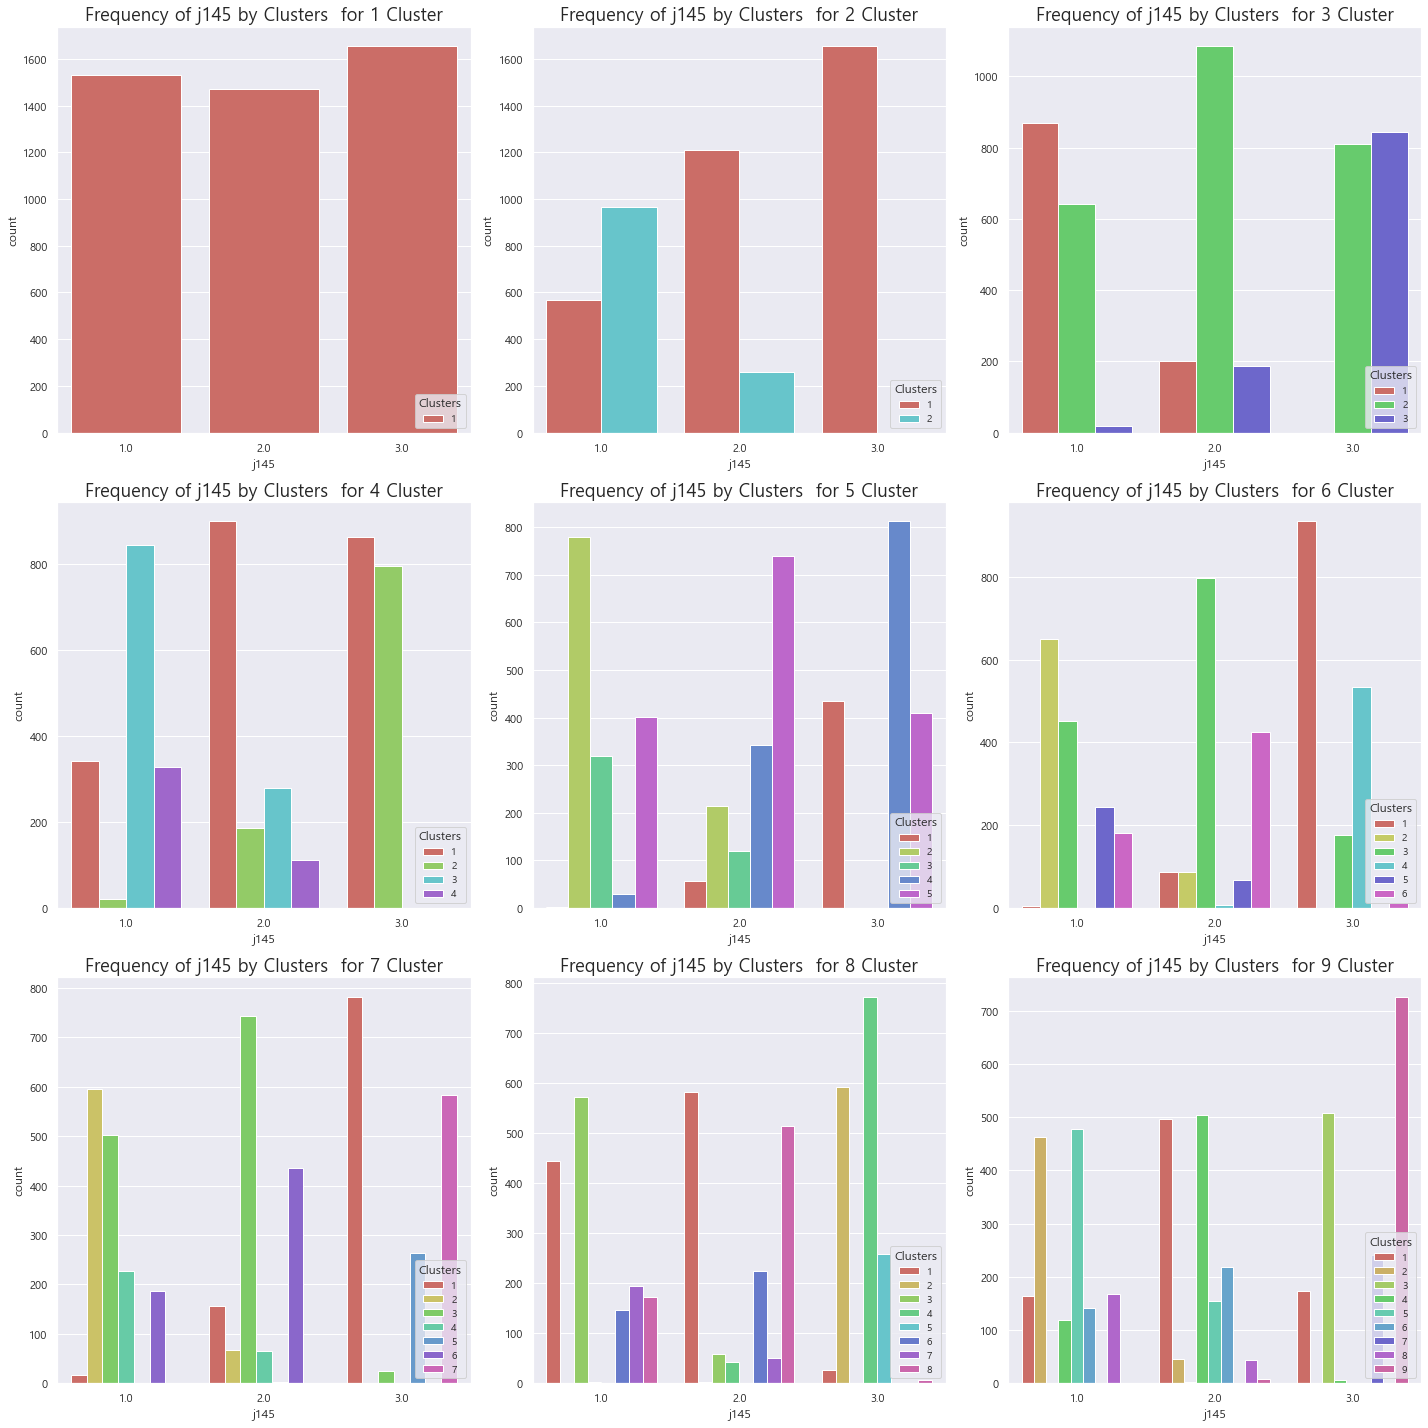

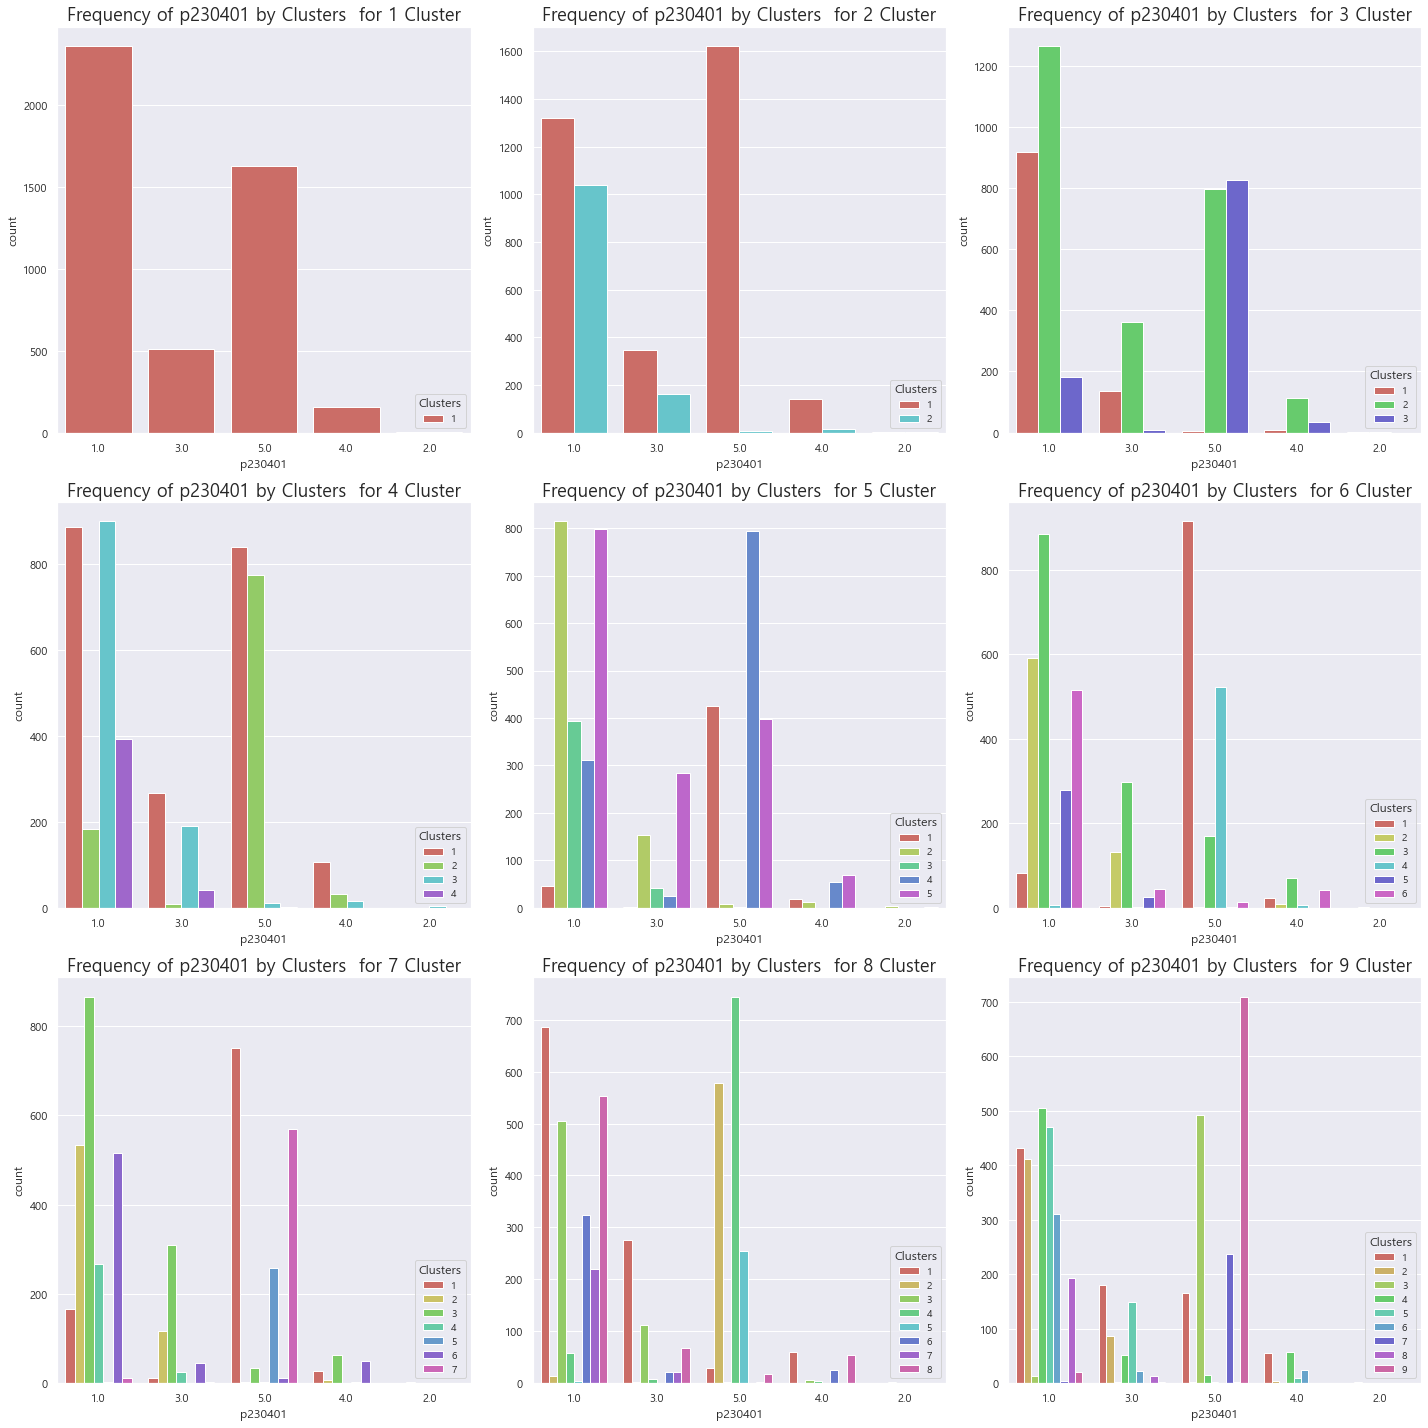

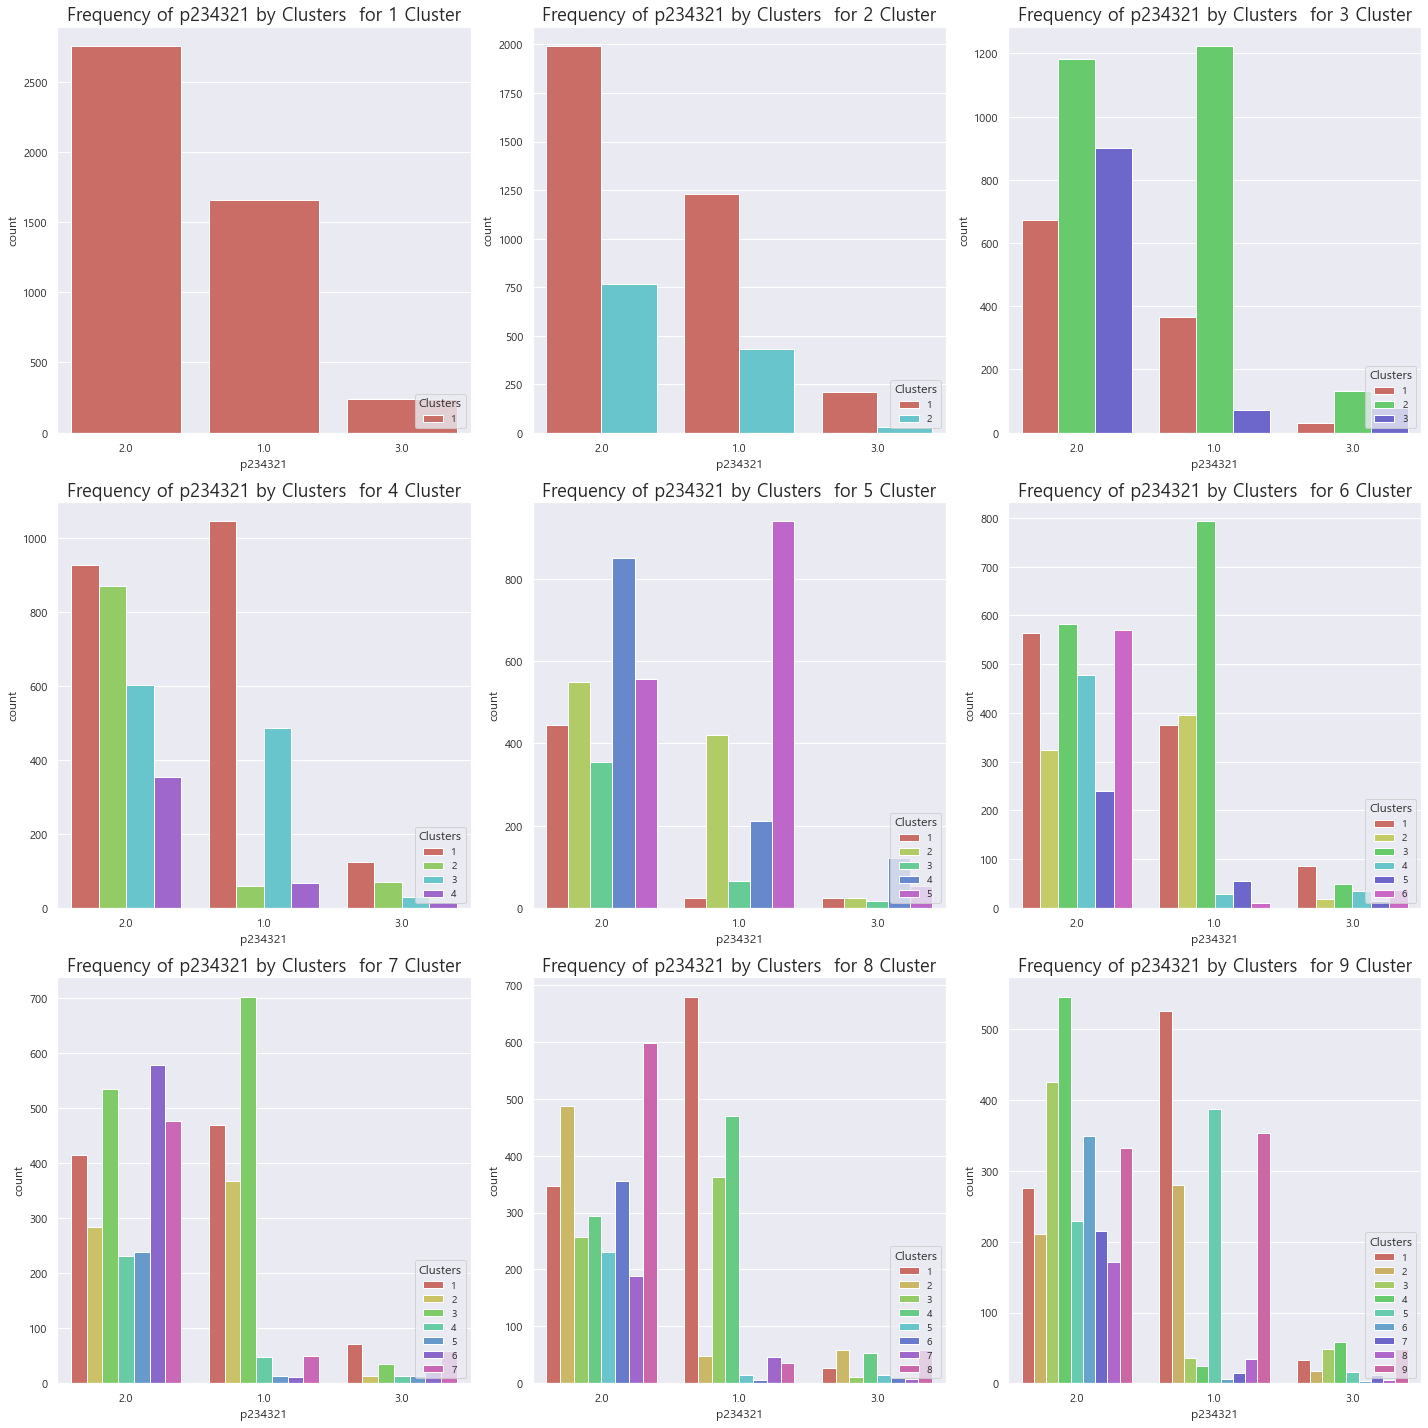

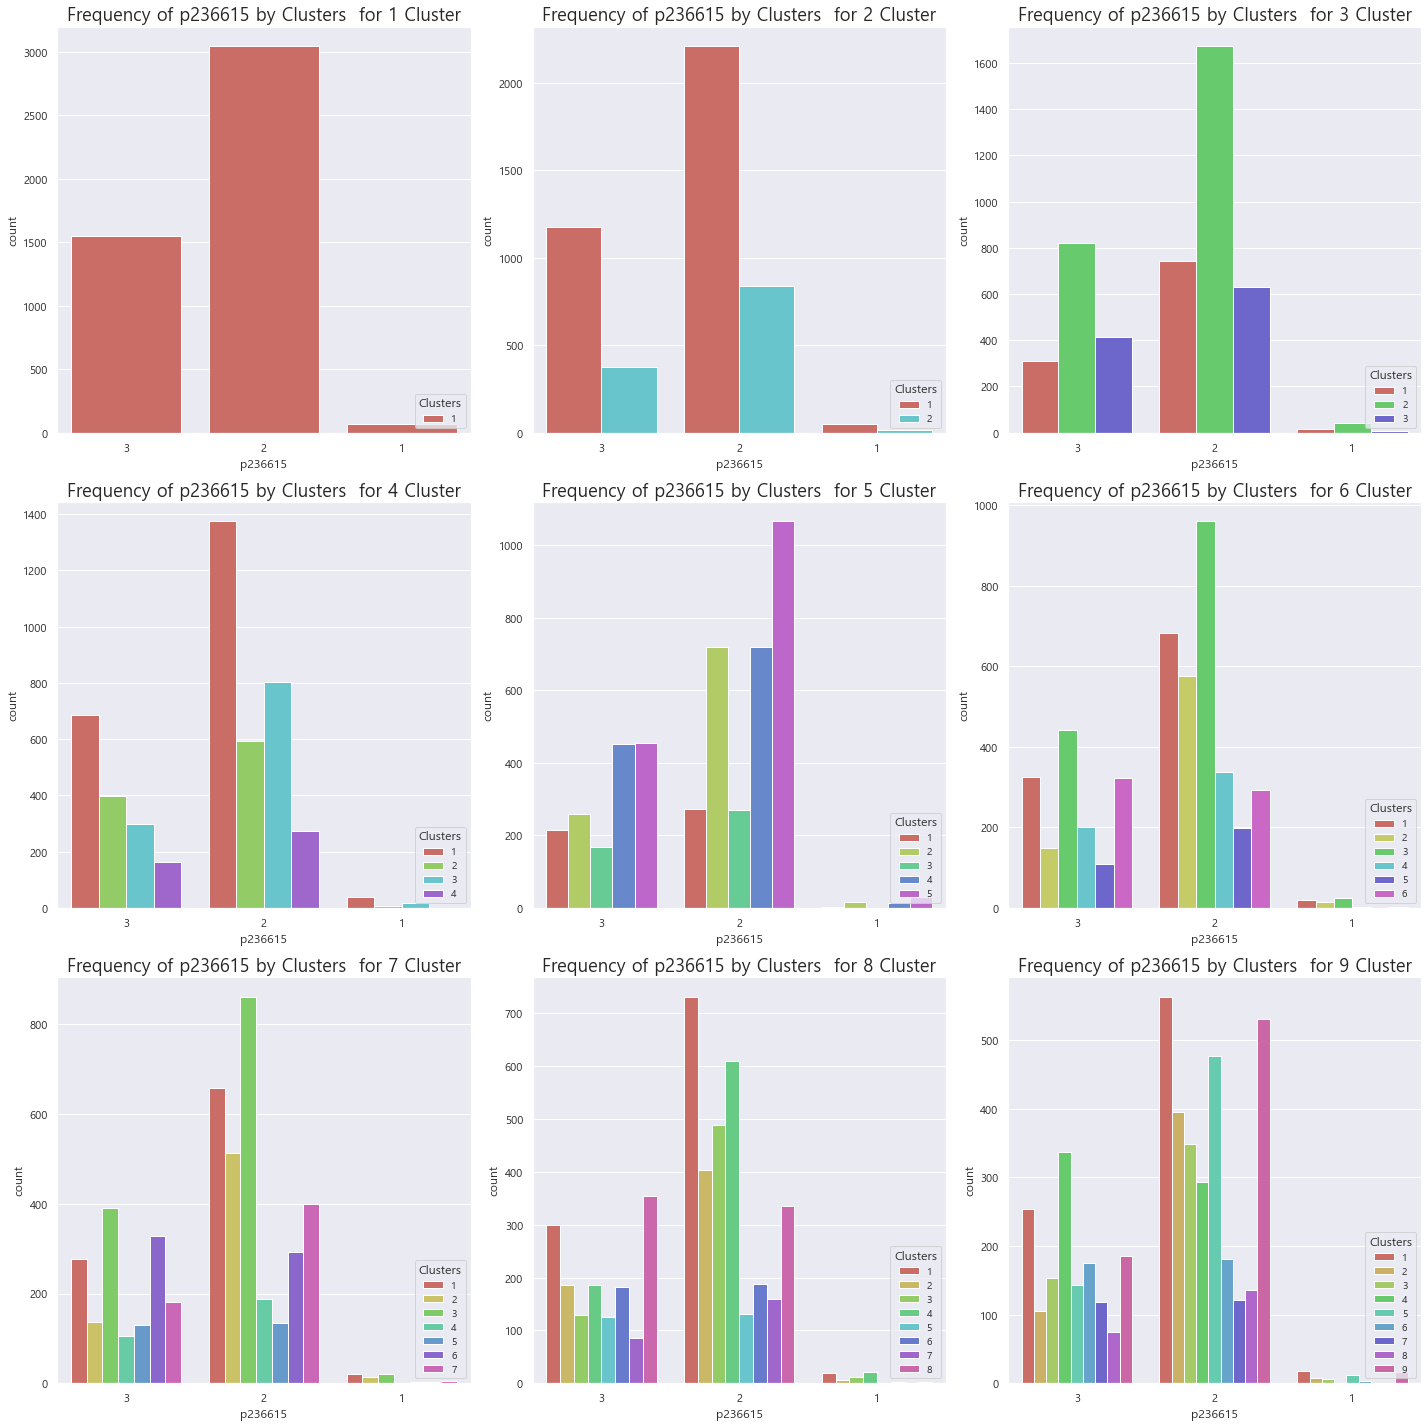

In [24]:
for colname in ['p230101', 'KSIC', 'jobtype', 'j145', 'p230401', 'p234321', 'p236615']:
    drawCountPlot(df_kmeans, colname)
#    (성별) p230101       (산업대분류) KSIC     (일자리형태) jobtype                    (고용형태) j145      
#    1: 남                                      1: 임금근로자                           1. 정규직            
#    2: 여                                      2: 비임금근로자                         2. 비정규직          
#                                                                                       3. 해당없음          
                                                                
#    (기업형태) p230401                        (전반적일자리만족도) p234321             (사회경제적지위) p236615    
#    1. 민간회사 또는 개인사업체               1. 만족                                  1. 상               
#    2. 외국인 회사                            2. 보통                                  2. 중               
#    3. 정부기관,법인단체,공사합동기업         3. 불만족                                3. 하              
#    4. 기타 또는 소속없음
#    5. 해당없음

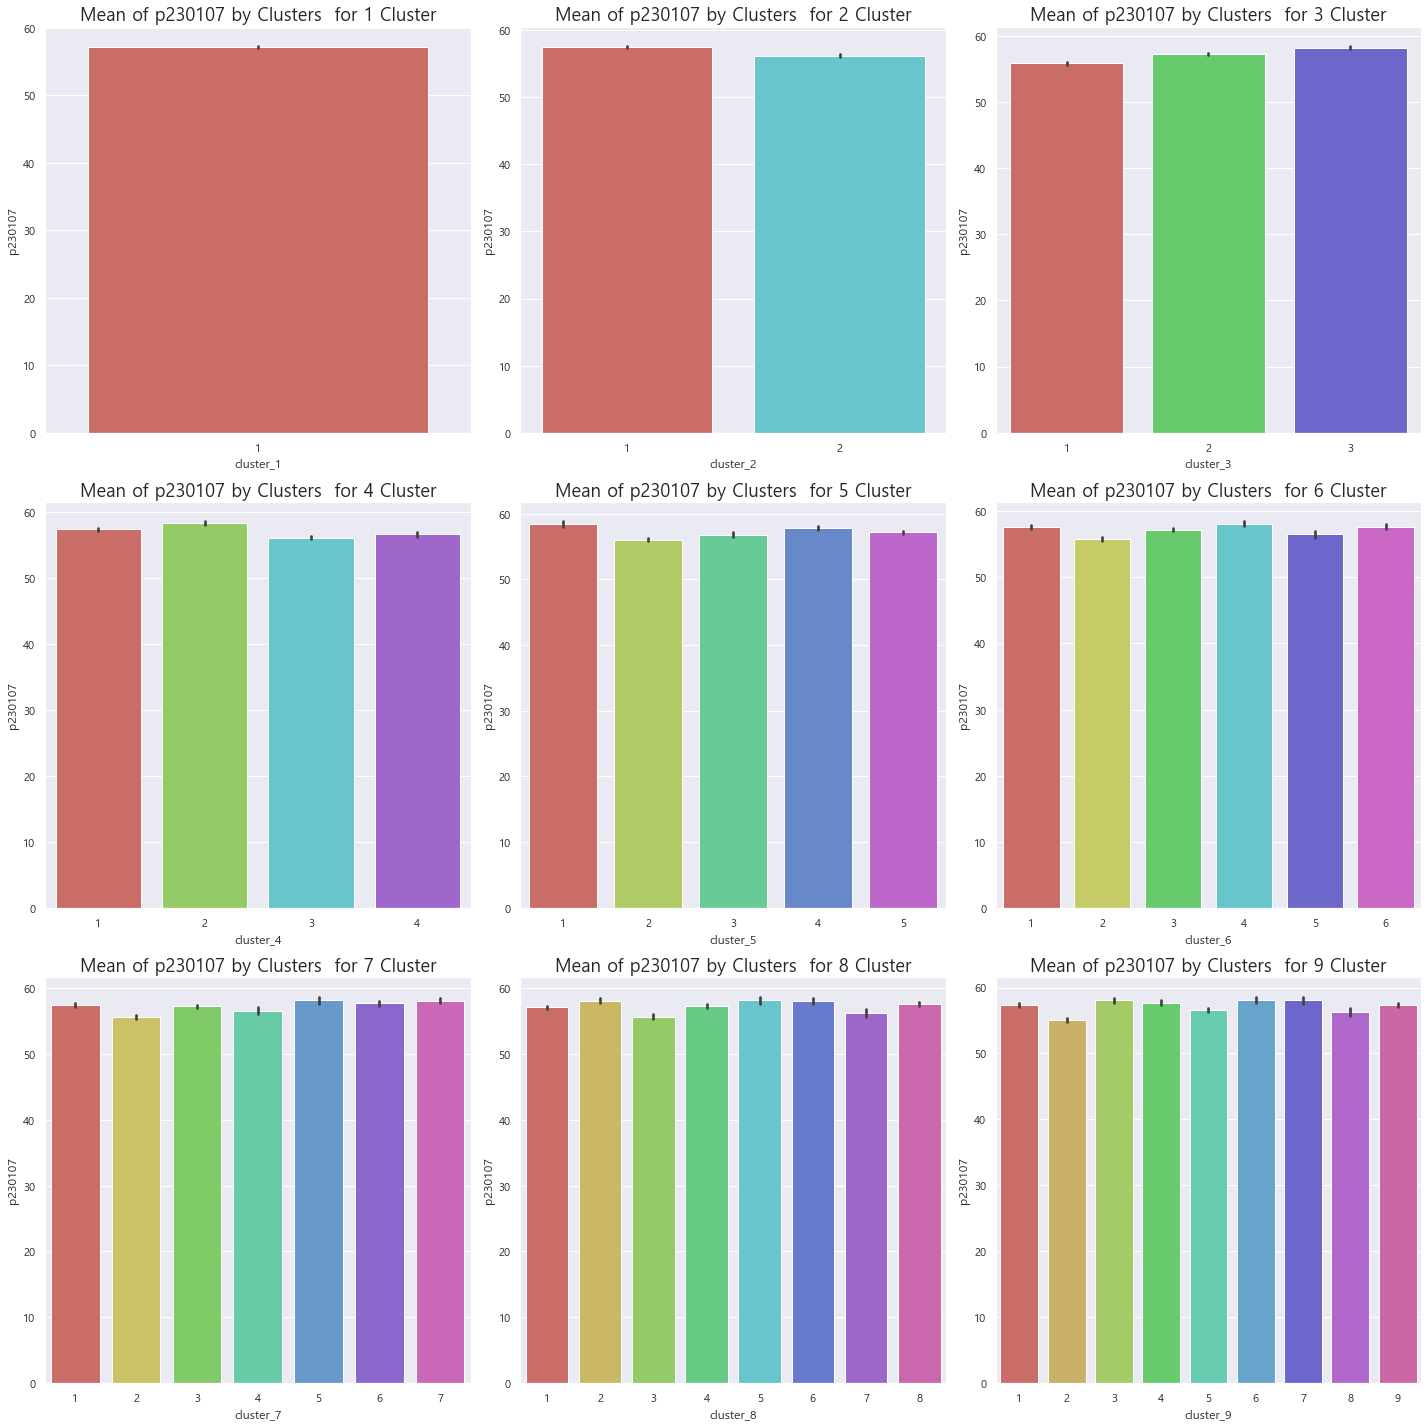

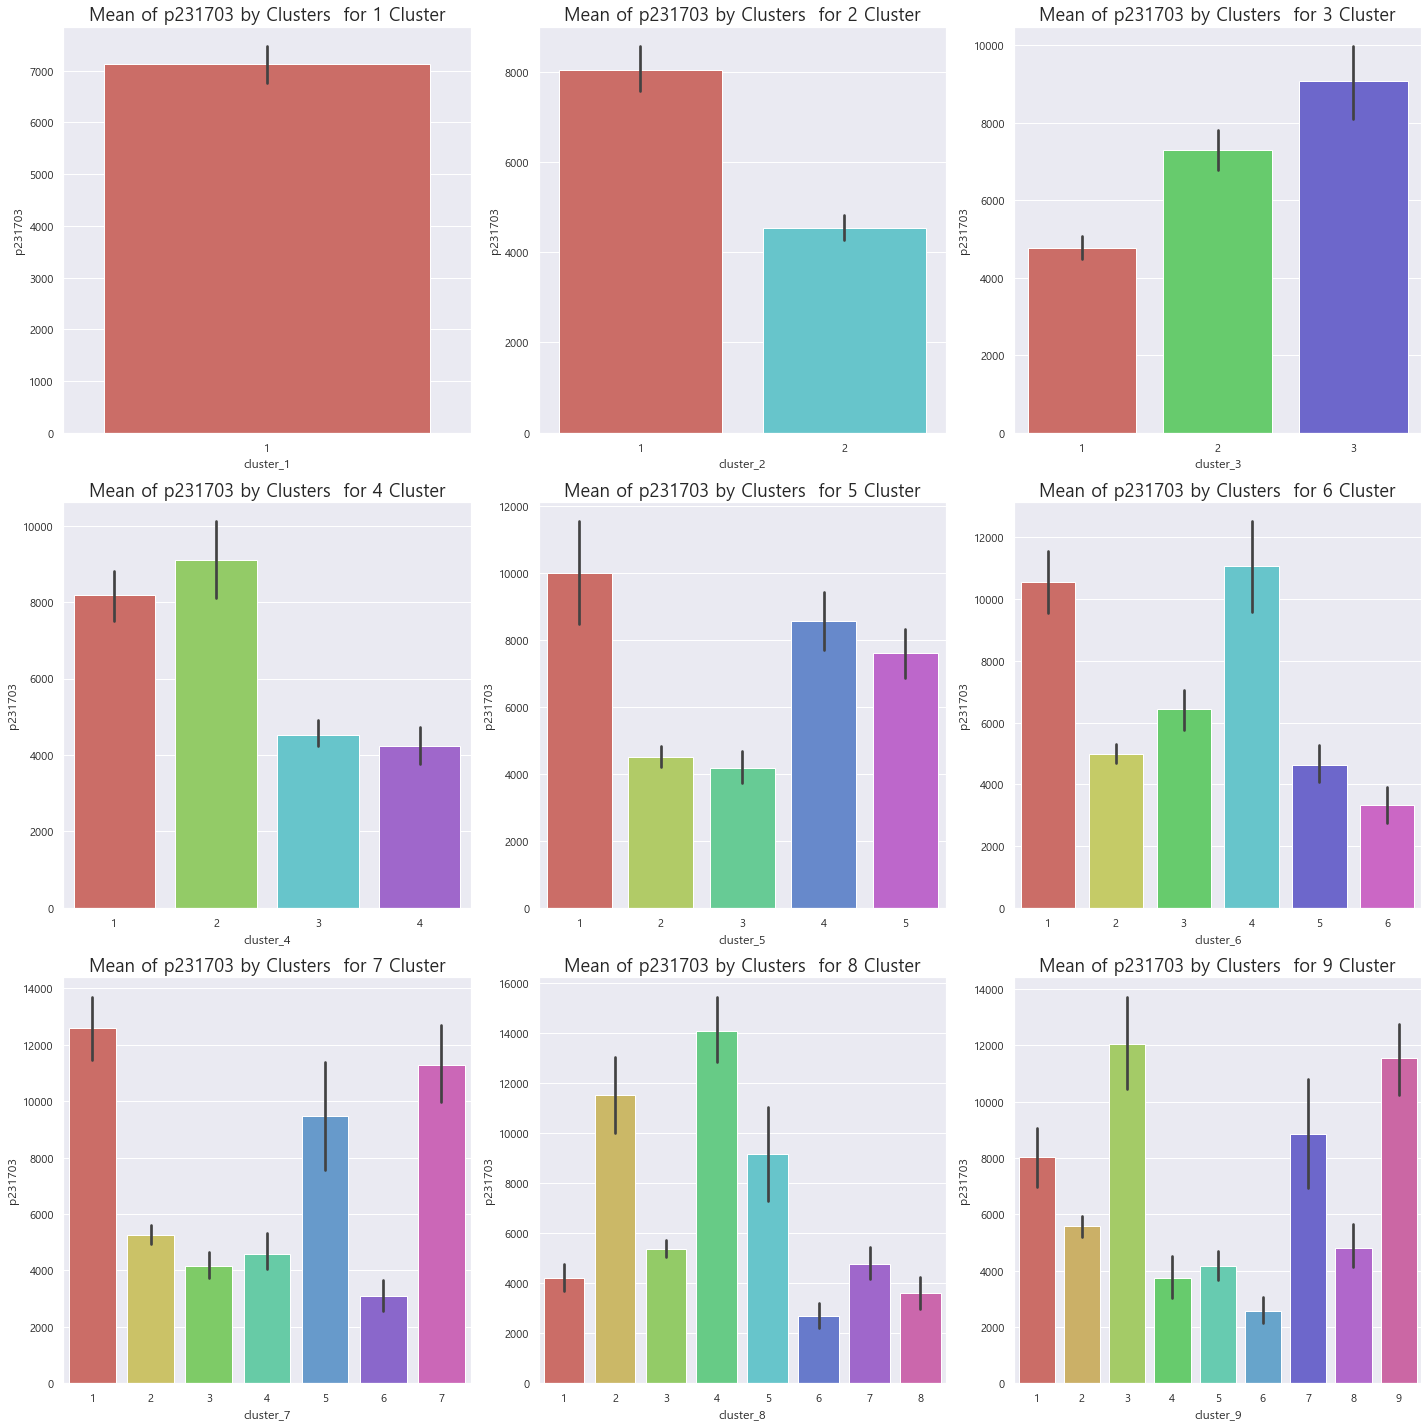

In [25]:
# 군집별 연속 변수의 평균 그래프
def drawMeanPlot(df, colname) : # (데이터 셋, 변수이름)
    clusters = [col for col in df.columns[60:69]]
    fig = plt.figure(figsize=(20,20))
    axes = [i+331 for i in range(9)]

    for i, (cluster,ax) in enumerate(zip(clusters, axes)):
        axs = fig.add_subplot(ax)
        sns.barplot(data=df, x=cluster, y=colname, palette=cms[i],ax=axs)
        axs.set_title( 'Mean of '+ colname+ ' by Clusters '+ ' for ' +  str(i+1) + ' Cluster',fontsize=18)

    plt.tight_layout(h_pad=1, w_pad=1)
    plt.show()
    
for colname in ['p230107','p231703']:
    drawMeanPlot(df_kmeans, colname)
    
# (나이) p230107
# (작년세후연간근로소득) p231703

## Cluster K 결정 후 산점도, 빈도, 평균 그래프 시각화
* K = 6
* 클러스터 그룹별 인구, 사회-경제적, 건강 특성에 따른 그래프 출력

In [26]:
cms[5]

[(0.86, 0.3712, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999)]

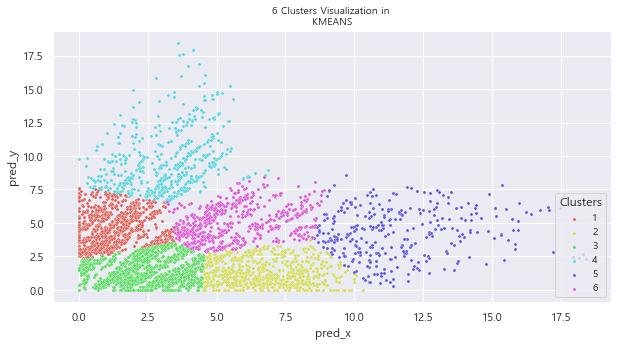

In [27]:
# 클러스터 산점도 그래프
def drawOneClusterScatter(df, cluster):
    fig = plt.figure(figsize=(10,5))
    n = int(cluster[-1])
    for i in range(n):
        marker_ind = df[df[cluster]==i+1].index
        sns.scatterplot(x=df.loc[marker_ind, 'pred_x'],
                y=df.loc[marker_ind, 'pred_y'],
                marker='o', s=10, color=cms[n-1][i])
    plt.title(str(n) + ' Clusters Visualization in \n' + 'KMEANS',fontsize=10)
    plt.legend(labels=[i+1 for i in range(n)] ,fontsize=10,title='Clusters',loc='lower right')
    plt.show()
    
drawOneClusterScatter(df_kmeans, 'cluster_6')

In [28]:
# 요인에 따른 클러스터 그룹별 빈도 그래프
def drawOneClusterCountPlot(df, cols, cluster):
    f, axs = plt.subplots(len(cols), 1, figsize=(10,30))
    n = int(cluster[-1])
    for i, col in enumerate(cols):
        ax = sns.countplot(x=df[col], order=None , hue=df[cluster],ax=axs[i], palette=cms[n-1])
        axs[i].set_title('Frequency of '+ col + ' by ' + str(n) + ' Cluster' ,fontsize=13)
        axs[i].legend(labels=[i+1 for i in range(n)] ,fontsize=10,title='Clusters',loc='upper right', 
                      bbox_to_anchor=(1.04,1))
    plt.tight_layout()
    plt.show()

In [29]:
# 요인에 따른 클러스터 그룹별 평균 그래프
def drawOneClusterMeanPlot(df, cols, cluster):
    f, axs = plt.subplots(len(cols), 1, figsize=(8,10))
    n = int(cluster[-1])
    for i, col in enumerate(cols):
        ax = sns.barplot(data=df, x=cluster, y=col, palette=cms[n-1], ax = axs[i],ci=None)
        axs[i].set_title('Mean of '+ col + ' by ' + str(n) + ' Cluster',fontsize=15)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2, height, int(height), ha = 'center', size = 9)
    plt.tight_layout(h_pad=1, w_pad=1)
    plt.show()


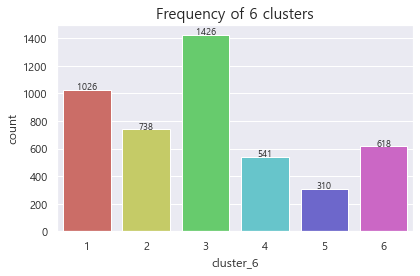

In [30]:
# 클러스터 빈도 그래프
def drawFrequencyCluster(colname):
    n = int(colname[-1])
    ax = sns.countplot(x=df_kmeans[colname], palette=cms[5])
    ax.set_title('Frequency of '+ str(n) +' clusters',fontsize=15)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, int(height), ha = 'center', size = 9)
    plt.tight_layout()
    plt.show()
    
drawFrequencyCluster('cluster_6')
    

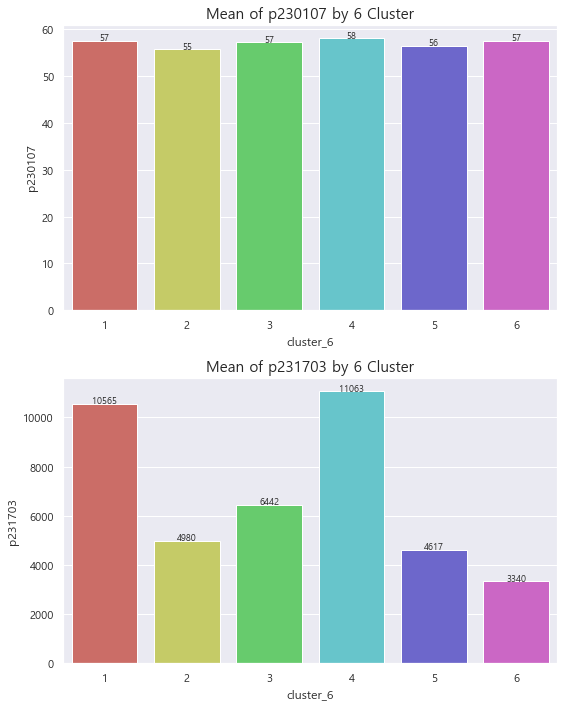

In [31]:
# 클러스터 그룹별 인구, 사회 경제적 특성에 따른 평균 그래프
# (나이) p230107
# (작년연간세후근로소득) p231703
drawOneClusterMeanPlot(df_kmeans, ['p230107','p231703'], 'cluster_6')

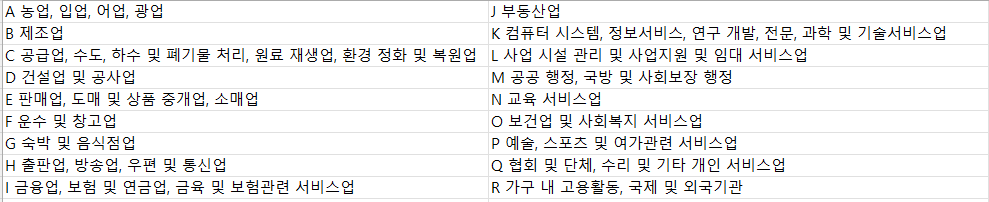

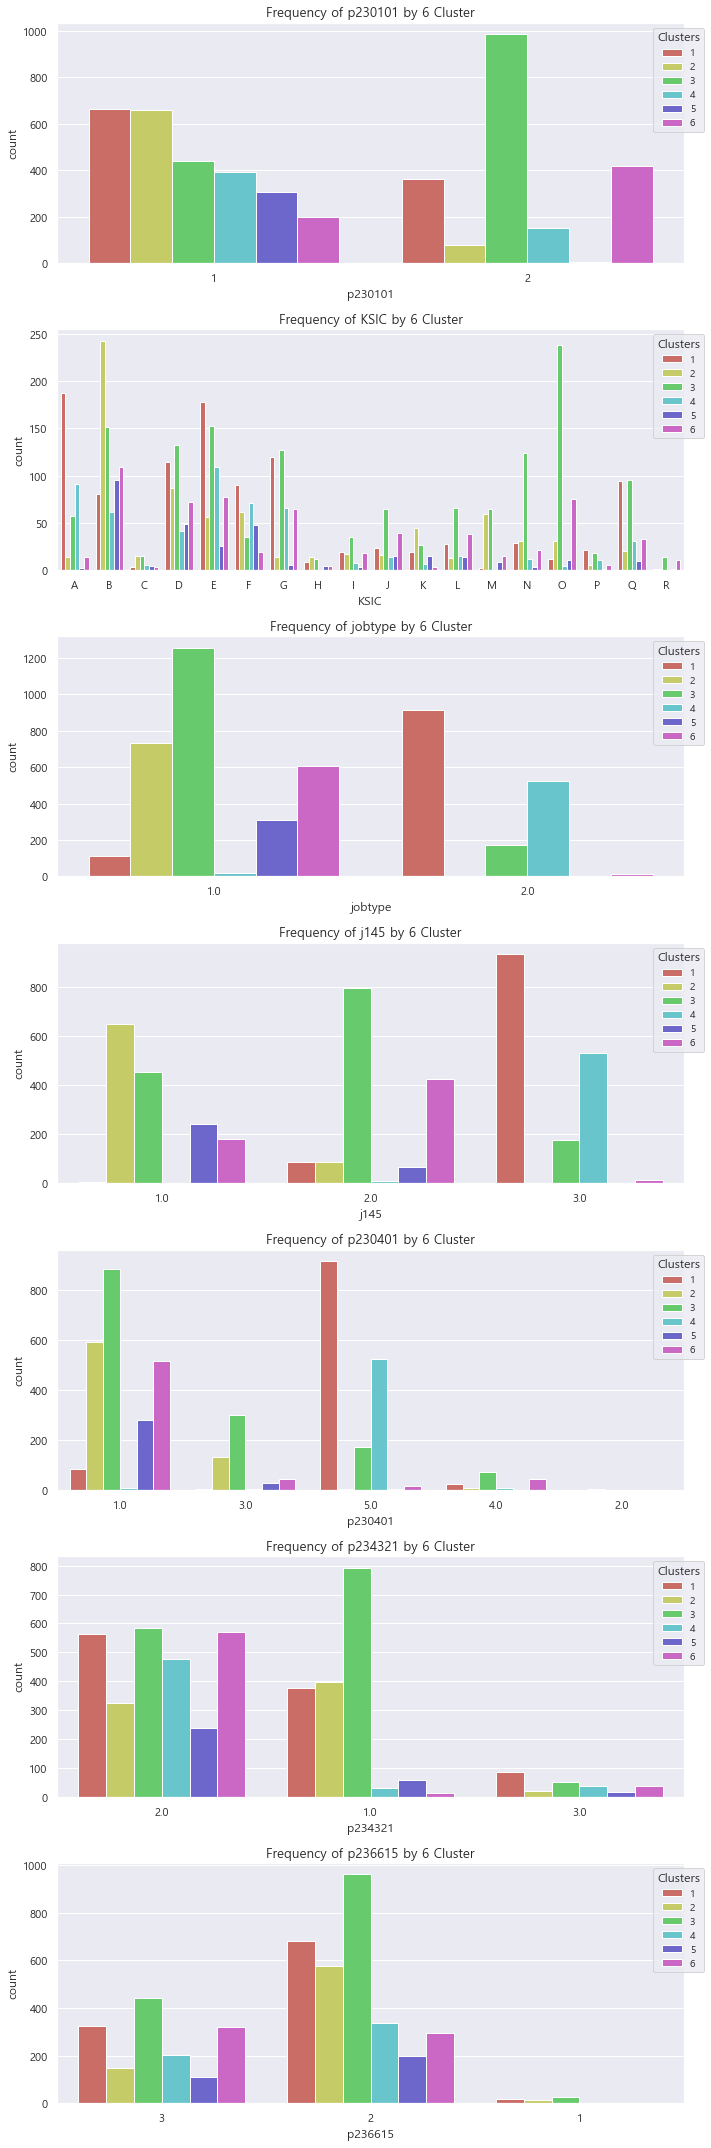

In [32]:
# 인구, 사회 - 경제적 특성에 따른 빈도, 평균(근로소득) 그래프
# 산업대분류는 위의 표 참조
drawOneClusterCountPlot(df_kmeans, 
                        ['p230101', 'KSIC', 'jobtype', 'j145', 'p230401', 'p234321', 'p236615'],
                        'cluster_6')

#    (성별) p230101       (산업대분류) KSIC     (일자리형태) jobtype                    (고용형태) j145      
#    1: 남                                      1: 임금근로자                           1. 정규직            
#    2: 여                                      2: 비임금근로자                         2. 비정규직          
#                                                                                       3. 해당없음          
                                                                
#    (기업형태) p230401                        (전반적일자리만족도) p234321             (사회경제적지위) p236615    
#    1. 민간회사 또는 개인사업체               1. 만족                                  1. 상               
#    2. 외국인 회사                            2. 보통                                  2. 중               
#    3. 정부기관,법인단체,공사합동기업         3. 불만족                                3. 하              
#    4. 기타 또는 소속없음
#    5. 해당없음

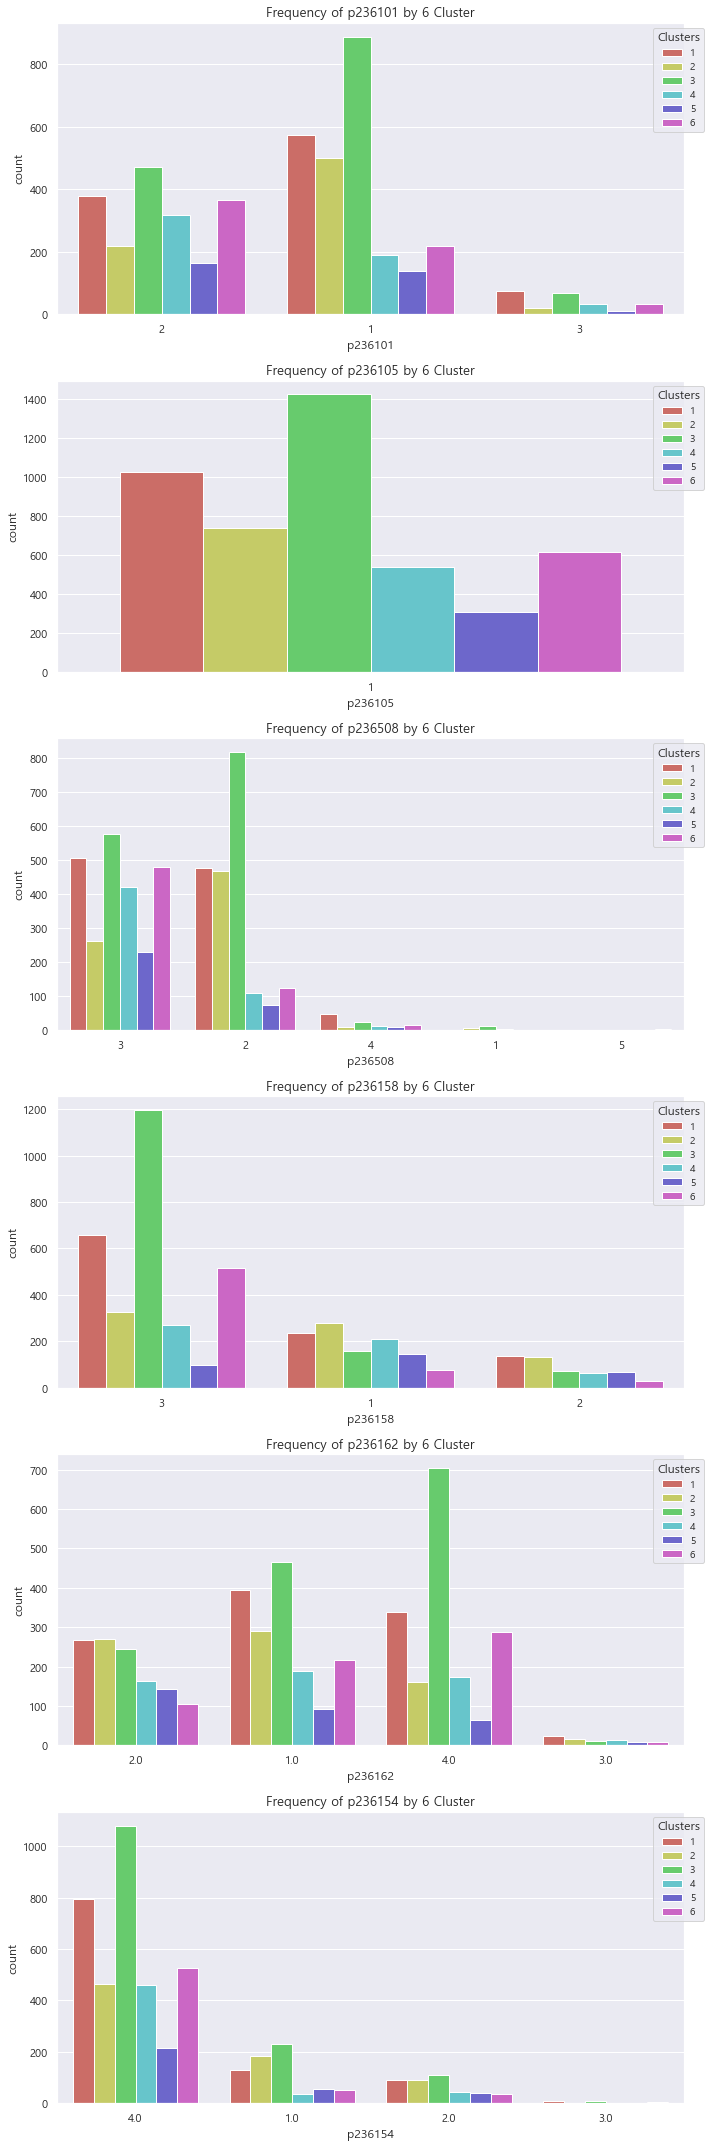

In [33]:
# 건강 특성에 따른 빈도 그래프
drawOneClusterCountPlot(df_kmeans, 
                        ['p236101', 'p236105', 'p236508', 'p236158', 'p236162', 'p236154'],
                        'cluster_6')

#   (현재건강상태) p236101                         (육체적제약) p236105           (전반적생활만족도) p236508
#   1. 좋음                                        1. 예                          1. 만족
#   2. 보통                                        2. 아니오                      2. 보통
#   3. 나쁨                                                                       3. 불만족

#   (흠연여부) p236158                            (음주빈도)p236162              (정기적운동여부) p236154
#   1. 피운다                                     1. 월 3회 이하                 1. 규칙적으로 한다.
#   2. 과거에는 피웠으나 현재에는 피우지 않는다   2. 주 4회 이하                 2. 불규칙적으로 또는 수시로 한다.
#   3. 피워본 적이 없다                           3. 거의 매일                   3. 거의 하지 않음
#   4. 해당없음                                   4. 안마심                      4. 해당없음


In [34]:
df_kmeans.to_excel('D:/klips_clustered.xlsx')